In [340]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns # gráficos
import matplotlib.pyplot as plt #visualizacion
from wordcloud import WordCloud
import missingno as msno # #Matriz de datos incompletos

# Pre procesamiento de texto
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet

#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

In [344]:
data = pd.read_csv('cyberbullying_tweets.csv')
data.head(10)

tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying
5  @Raja5aab @Quickieleaks Yes, the test of god i...  not_cyberbullying
6  Itu sekolah ya bukan tempat bully! Ga jauh kay...  not_cyberbullying
7  Karma. I hope it bites Kat on the butt. She is...  not_cyberbullying
8       @stockputout everything but mostly my priest  not_cyberbullying
9  Rebecca Black Drops Out of School Due to Bully...  not_cyberbullying

In [346]:
# checking shape of the data
print("There are", data.shape[0], 'rows and', data.shape[1], "columns.")

There are 47692 rows and 2 columns.


In [348]:
data.info() # Data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [350]:
data.isnull().sum() #Missing values

tweet_text            0
cyberbullying_type    0
dtype: int64

<Axes: >

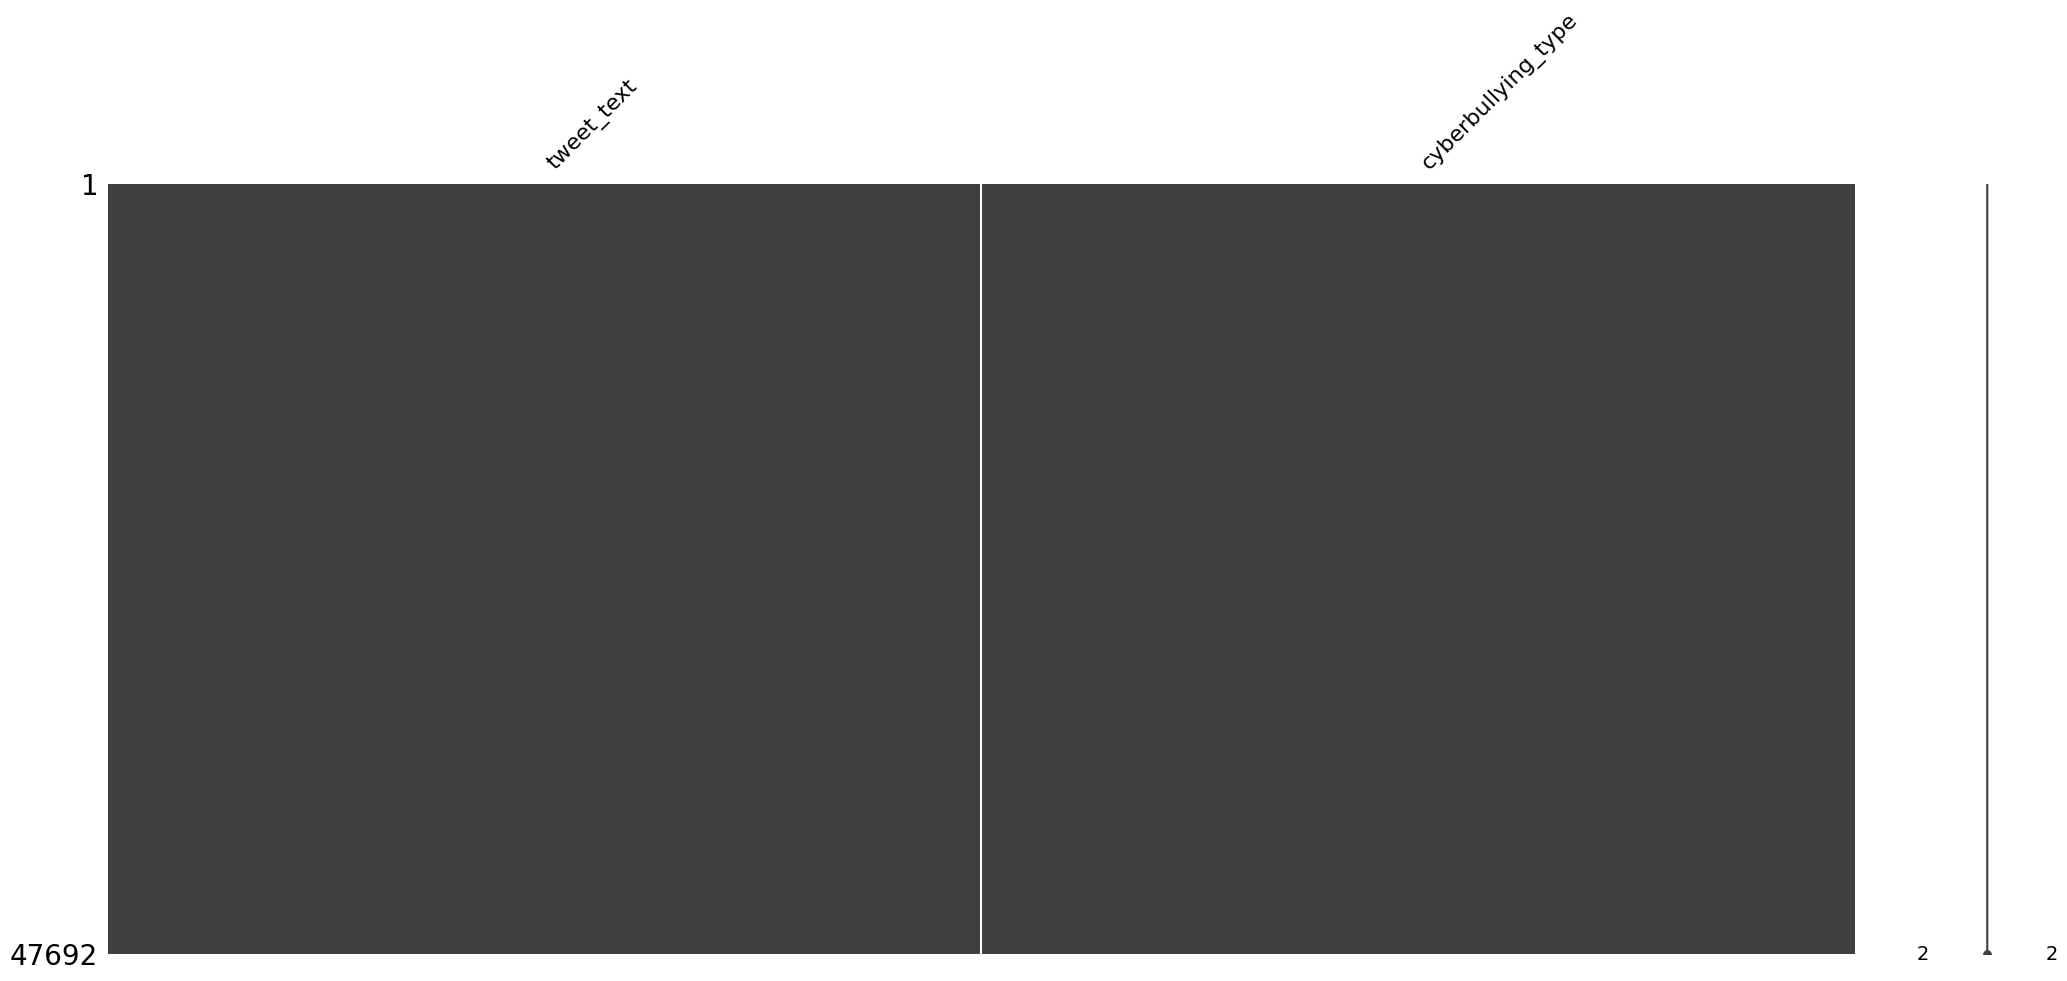

In [352]:
msno.matrix(data)

In [354]:
data.duplicated().sum() #Duplicates

36

In [356]:
data.drop_duplicates(inplace=True) #Drops duplicates
data.reset_index(drop=True,inplace=True) #Resets index

In [358]:
data['cyberbullying_type'].value_counts() #Tweets distribution between classes

cyberbullying_type
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64

In [360]:
data.describe() # Important and unique values

tweet_text cyberbullying_type
count                                               47656              47656
unique                                              46017                  6
top     @sschinke @Blackamazon @shanley also sorta wor...           religion
freq                                                    2               7997

In [362]:
cuenta = data["tweet_text"].value_counts() #Counts unique values
print(f'Hay {len(cuenta[cuenta>=2])} tweets dobles.') # Amount of repeated tweets

Hay 1639 tweets dobles.


In [364]:
repetidos = cuenta[cuenta>=2].index # Object with the index of tweets with 2 or more ocurrencies
duplicados = data[data["tweet_text"].isin(repetidos)]# Filters the DF with the repeated
tipos = duplicados["cyberbullying_type"].value_counts() #Filters the DF w/type of CB
print(tipos)

cyberbullying_type
other_cyberbullying    1580
not_cyberbullying      1509
gender                  176
ethnicity                 7
religion                  6
Name: count, dtype: int64


In [366]:
grouped = duplicados.groupby('tweet_text')['cyberbullying_type'].unique() # Groups by cyberbullying type
grouped = grouped.reset_index() # Convert to DF 
grouped.columns = ['tweet_text', 'cyberbullying_types'] # With column names
grouped[-10:]

tweet_text  \
1629      vomit. #stopwadhwa2015 http://t.co/78tLSv56cs   
1630          wadhwa is now blaming npr for bad health.   
1631    why is their whole menu dick related?!?!?! #MKR   
1632  yes i turned on profanity filter because i'm t...   
1633  yesssssssss https://t.co/SwnavDvwzD  @lukemcki...   
1634  you know, that's an interesting idea. Maybe I ...   
1635  your face is awful. @DarkSim7 @InvisibleJimBSH...   
1636  ~10% of the posts I've read on Facebook today ...   
1637  “@BurrawongGaian: @Le_bon_vivant_ @ConjurupFoo...   
1638  “The Fat Girl Behind the Fitness App” by @naom...   

                           cyberbullying_types  
1629  [not_cyberbullying, other_cyberbullying]  
1630  [not_cyberbullying, other_cyberbullying]  
1631  [not_cyberbullying, other_cyberbullying]  
1632  [not_cyberbullying, other_cyberbullying]  
1633  [not_cyberbullying, other_cyberbullying]  
1634  [not_cyberbullying, other_cyberbullying]  
1635  [not_cyberbullying, other_cyberbullying]  
1636  [not_cyberbullying, other_cyberbullying]  
1637  [not_cyberbullying, other_cyberbullying]  
1638               [not_cyberbullying, gender]

In [368]:
# Drops ambiguous entries
conflict_mask = (data.groupby('tweet_text')['cyberbullying_type'].transform('nunique') > 1)
data = data[~conflict_mask].reset_index(drop=True)

In [370]:
data.shape

(44378, 2)

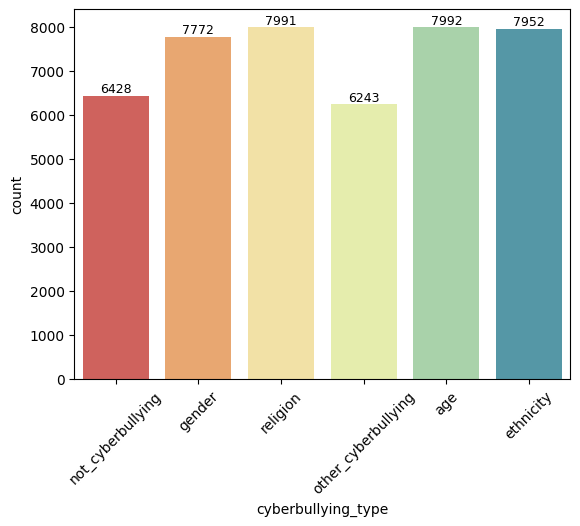

In [331]:
#Graphic of distribution of type of CB   
ax= sns.countplot(data=data,x='cyberbullying_type', hue='cyberbullying_type', palette='Spectral', legend=False)
plt.xticks(rotation=45)

for container in ax.containers: # Values of each bar
    ax.bar_label(container, label_type='edge', fontsize=9)
plt.show()

## Wordcloud - Histograma de barras

In [382]:
# Preprocessing
lemmatizer = WordNetLemmatizer() # Creates lemmatizer

def get_wordnet_pos(tag): # Map POS tags to WordNet format
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def lemmatizer_words(text): # Creates function to tokenize and lemmatize
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens) #Part-of-speech tag
    lemmatized = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(tag)) for word, tag in tagged]
    return " ".join(lemmatized)

data['tweet_text']=data['tweet_text'].astype(str) # Turns object type to string type
data['tweet_text']=data['tweet_text'].apply(lambda text: lemmatizer_words(text)) # Lambda function to lemmatize a specific column

# Vectorizer and stop words removal
stopwords_especiales = ['rt', 'just', 'don', 'http', 'got', 'https', 'wa', 'amp', 've', 'mkr'] # List of domain-specific stop words
comb_stopwords = list(ENGLISH_STOP_WORDS.union(stopwords_especiales)) #Combine stop words

### Género

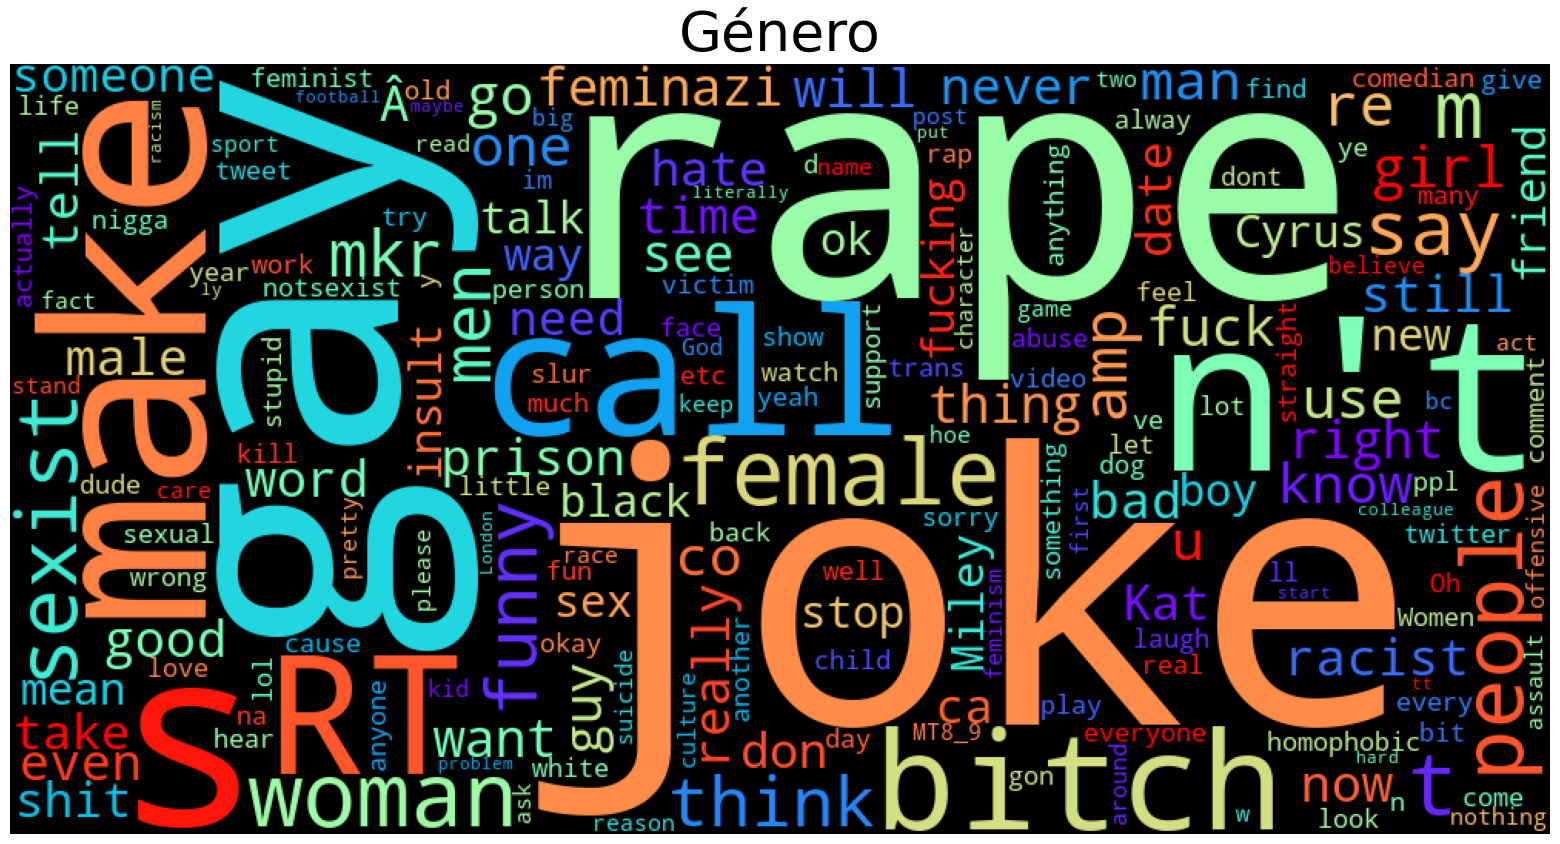

In [378]:
# Wordcloud of gender class CB
plt.figure(figsize=(20,10))
subset1 = data[data['cyberbullying_type']=='gender']
texto_genero = subset1.tweet_text.values
texto_genero = texto_genero.tolist()
cloud_genero=WordCloud(background_color='black',colormap="rainbow",collocations=False, width=1000,height=500).generate(" ".join(texto_genero))

plt.axis('off')
plt.title("Género",fontsize=40)
plt.imshow(cloud_genero)

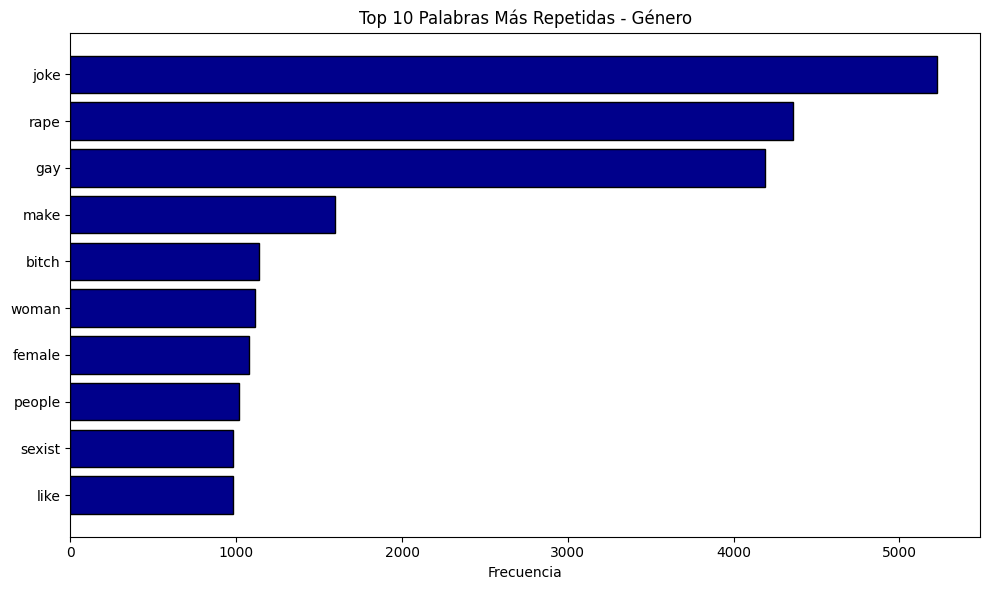

In [380]:
# Top 10 words of gender CB
def top_words(texto, top_k=10): # Defines function to retrieve the top 10 most common words
    vectorizer = CountVectorizer(stop_words=comb_stopwords) # Vectorizer with stop words removal
    X = vectorizer.fit_transform(texto)
    word_counts = X.toarray().sum(axis=0) # Word counts
    vocab = vectorizer.get_feature_names_out() # Gets the vocabulary
    word_freq = pd.DataFrame({'word': vocab, 'count': word_counts}) # Map words to their counts
    top_words = word_freq.sort_values(by='count', ascending=False).head(top_k) # Gets top k words
    
    return top_words
    
top_10_genero = top_words(texto_genero, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_genero['word'][::-1], top_10_genero['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - Género')
plt.tight_layout()
plt.show()

### Edad

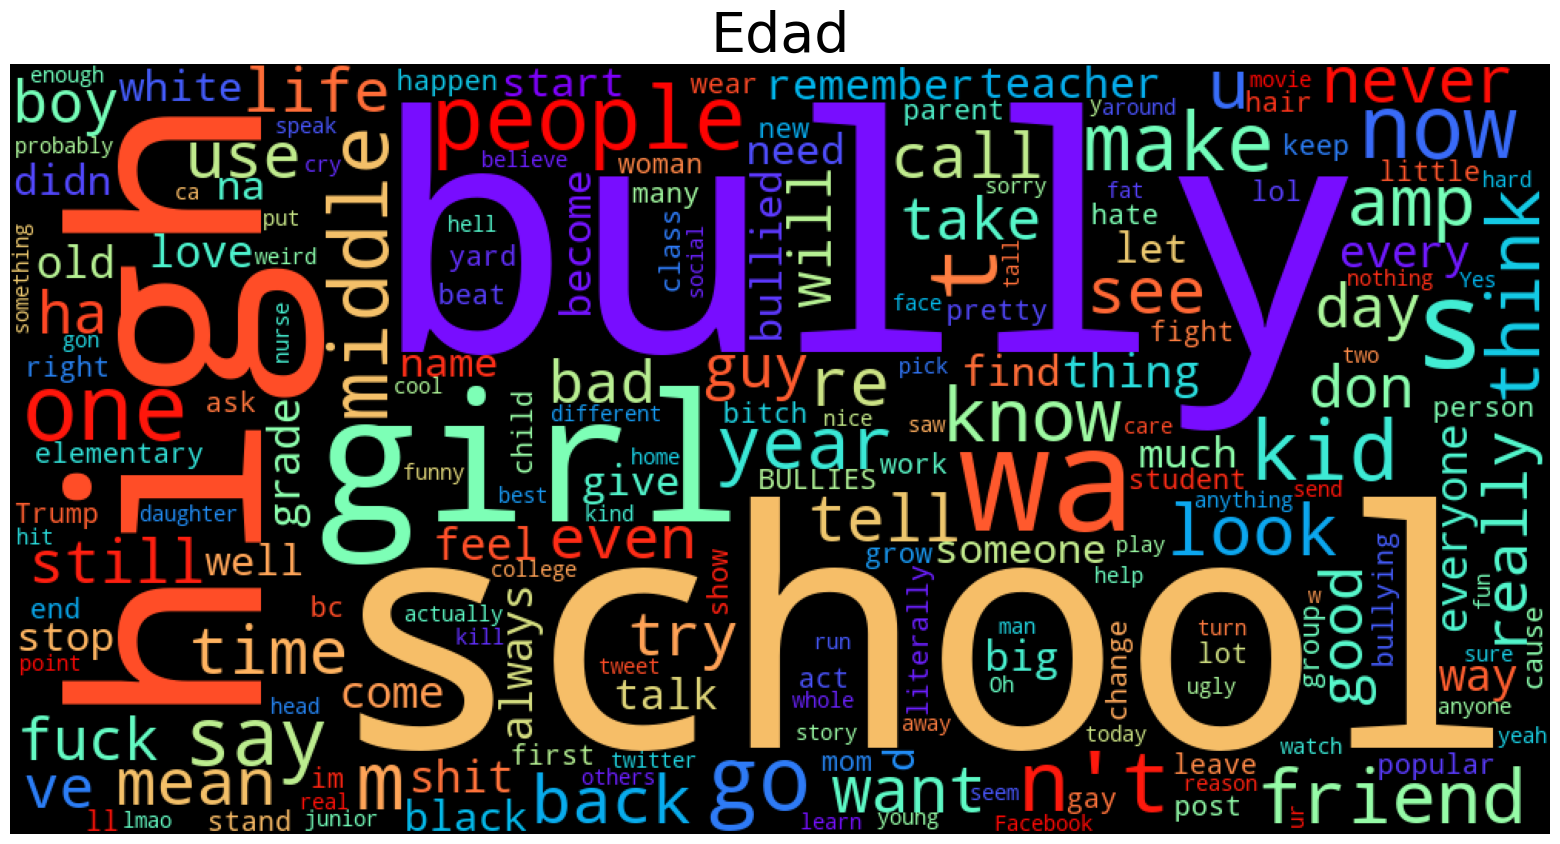

In [83]:
# Wordcloud of age class CB
plt.figure(figsize=(20,10))
subset2 = data[data['cyberbullying_type']=='age']
texto_edad = subset2.tweet_text.values
texto_edad = texto_edad.tolist()
cloud_edad=WordCloud(background_color='black',colormap="rainbow",collocations=False, width=1000,height=500).generate(" ".join(texto_edad))

plt.axis('off')
plt.title("Edad",fontsize=40)
plt.imshow(cloud_edad)

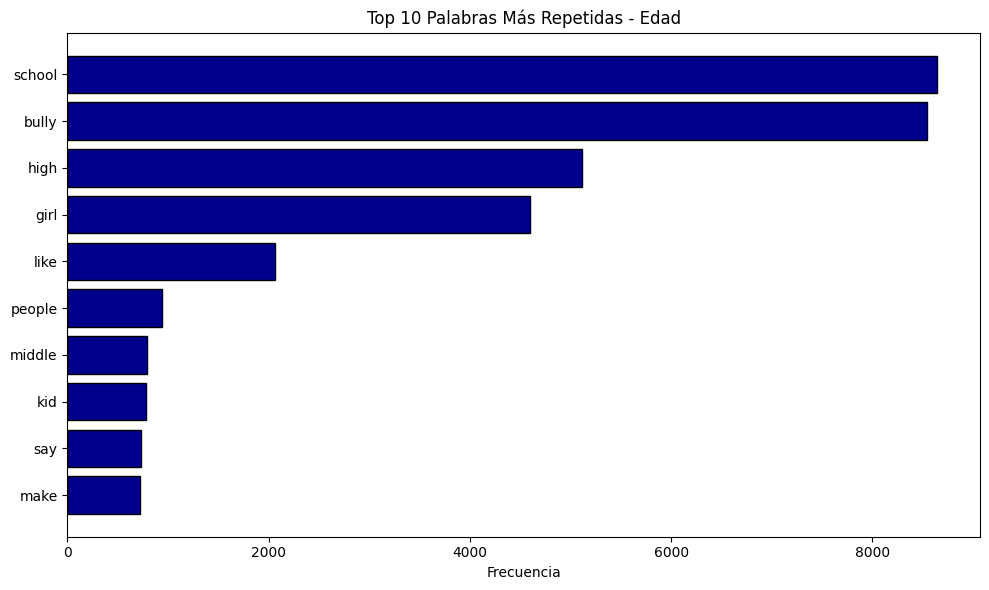

In [84]:
# Top 10 words of age CB
top_10_edad = top_words(texto_edad, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_edad['word'][::-1], top_10_edad['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - Edad')
plt.tight_layout()
plt.show()

### Religión

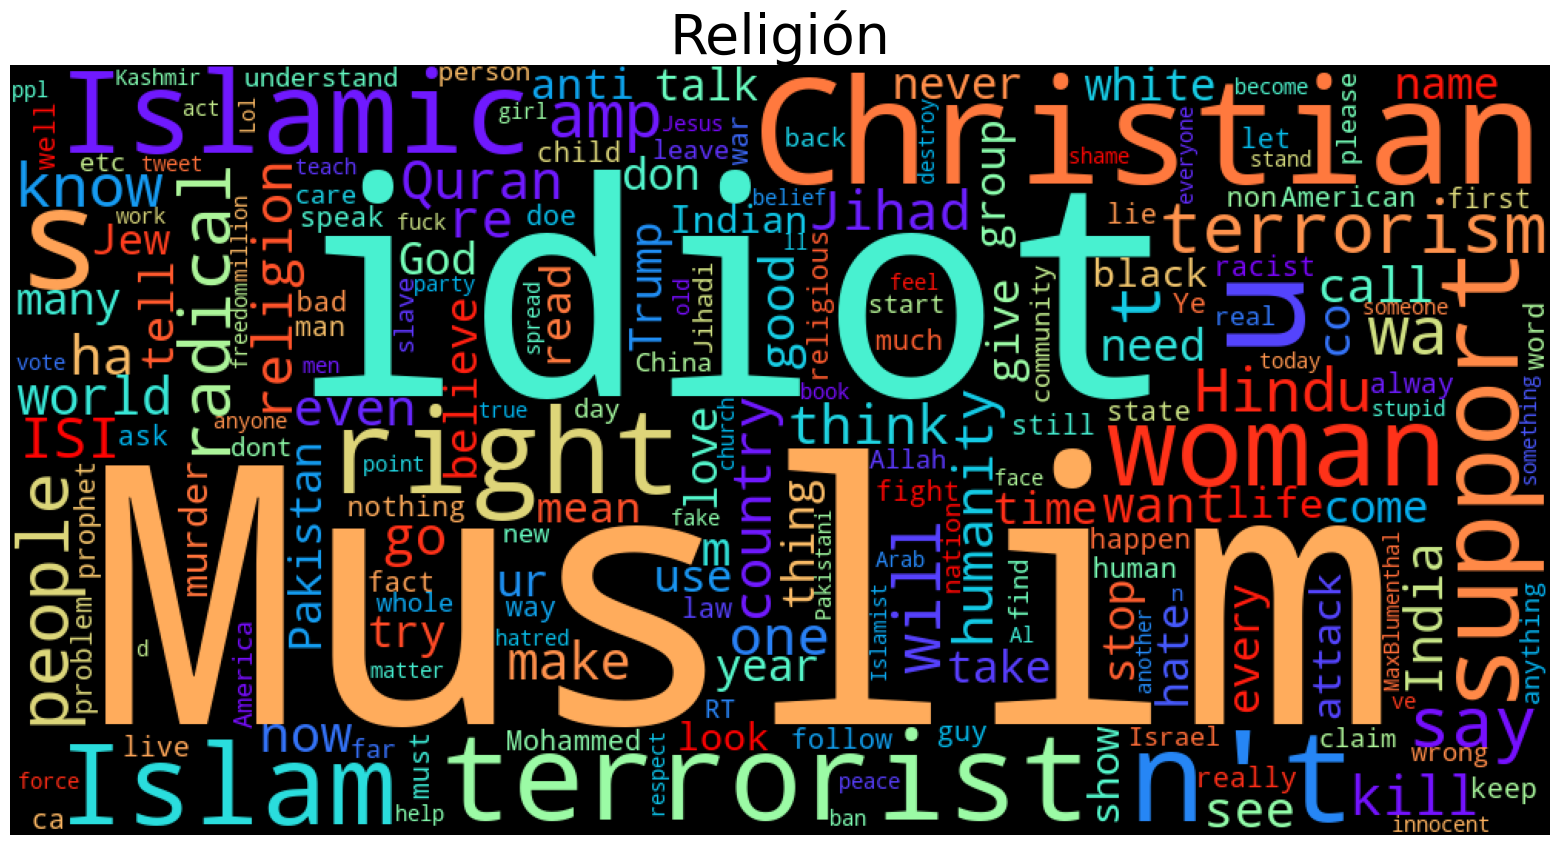

In [87]:
# Wordcloud of religion class CB
plt.figure(figsize=(20,10))
subset3 = data[data['cyberbullying_type']=='religion']
texto_reli = subset3.tweet_text.values
texto_reli = texto_reli.tolist()
cloud_reli=WordCloud(background_color='black',colormap="rainbow",collocations=False, width=1000,height=500).generate(" ".join(texto_reli))

plt.axis('off')
plt.title("Religión",fontsize=40)
plt.imshow(cloud_reli)

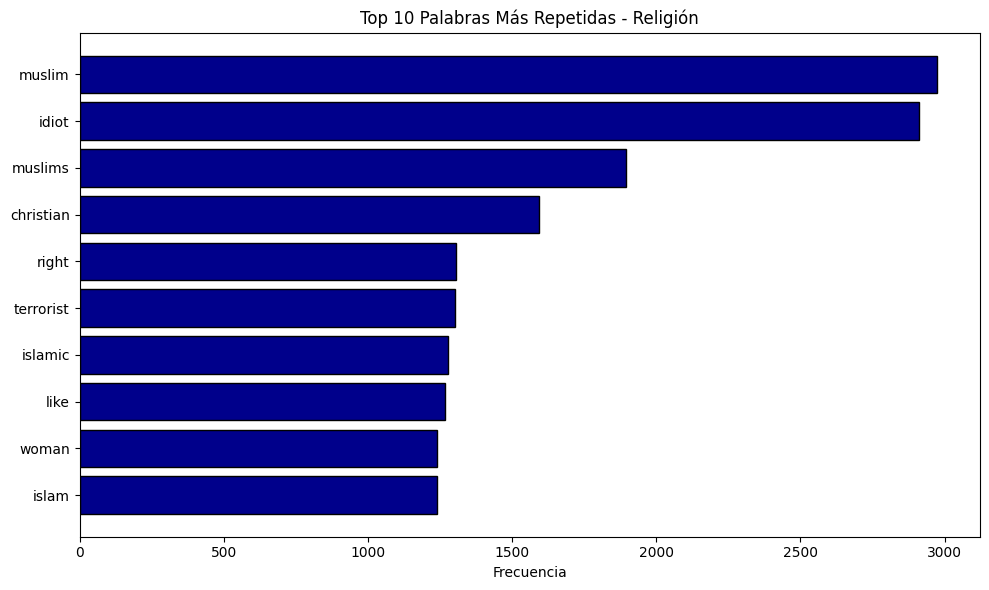

In [386]:
# Top 10 words of religion CB
top_10_reli = top_words(texto_reli, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_reli['word'][::-1], top_10_reli['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - Religión')
plt.tight_layout()
plt.show()

### Raza

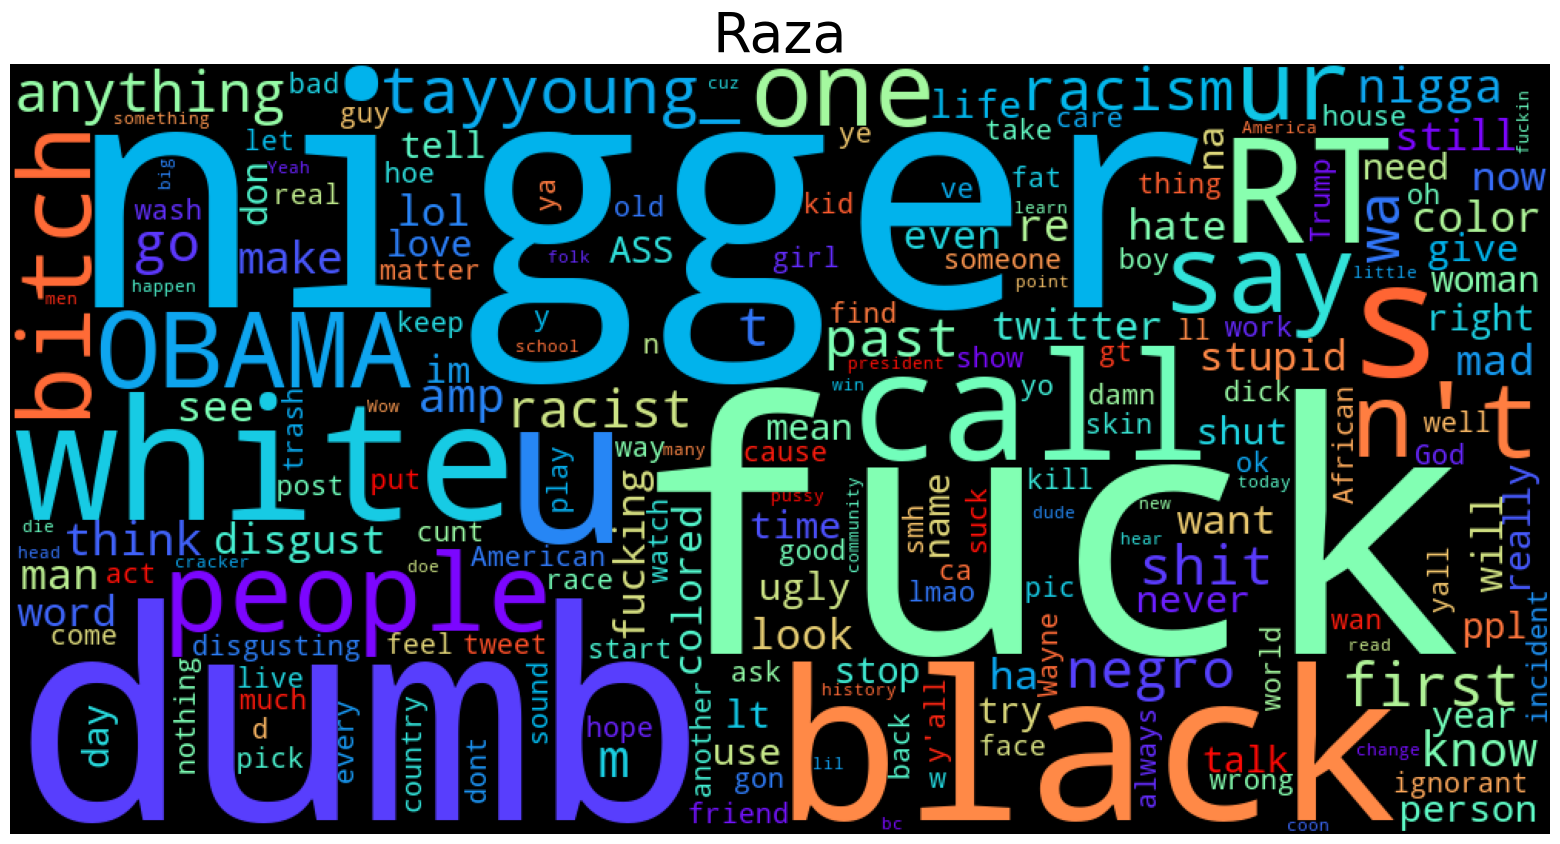

In [93]:
# Wordcloud of ethnicity class CB
plt.figure(figsize=(20,10))
subset4 = data[data['cyberbullying_type']=='ethnicity']
texto_raza = subset4.tweet_text.values
texto_raza = texto_raza.tolist()
cloud_raza = WordCloud(background_color='black',colormap="rainbow",collocations=False, width=1000,height=500).generate(" ".join(texto_raza))

plt.axis('off')
plt.title("Raza",fontsize=40)
plt.imshow(cloud_raza)

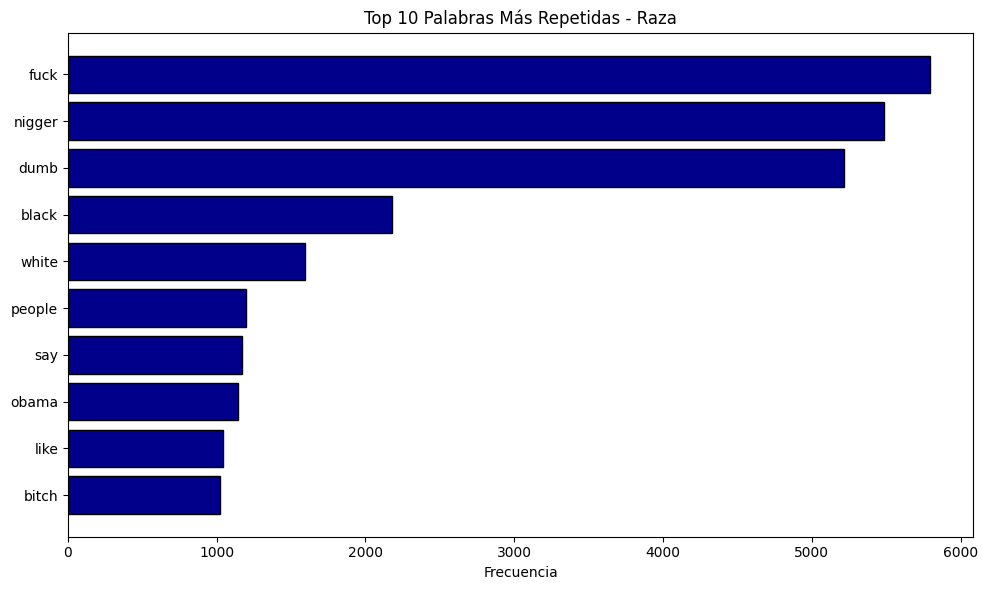

In [95]:
# Top 10 words of ethnicity CB
top_10_raza = top_words(texto_raza, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_raza['word'][::-1], top_10_raza['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - Raza')
plt.tight_layout()
plt.show()

### Otro tipo de ciberacoso

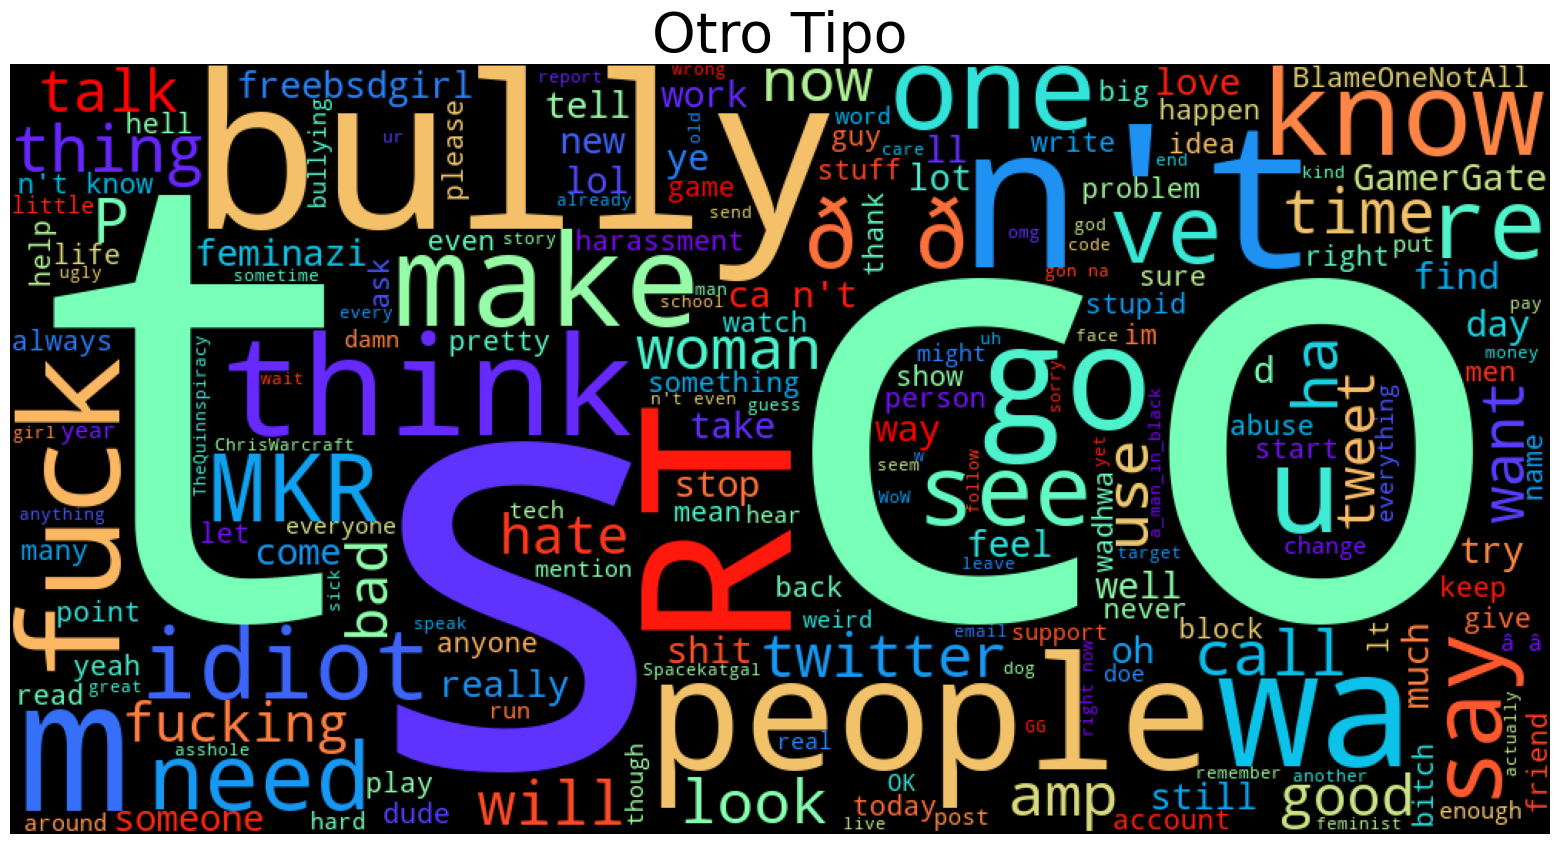

In [118]:
# Wordcloud of other CB
plt.figure(figsize=(20,10))
subset5 = data[data['cyberbullying_type']=='other_cyberbullying']
texto_otro = subset5.tweet_text.values
texto_otro = texto_otro.tolist()
cloud_otro =WordCloud(background_color='black',colormap="rainbow", collocations=True, width=1000,height=500).generate(" ".join(texto_otro))

plt.axis('off')
plt.title("Otro Tipo",fontsize=40)
plt.imshow(cloud_otro)

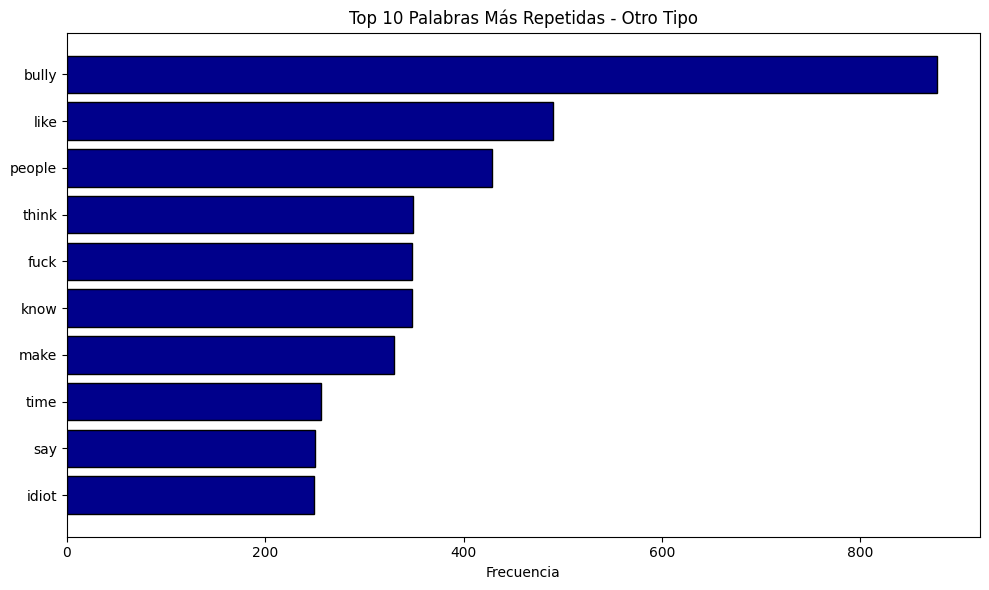

In [106]:
# Top 10 words of other CB
top_10_otro = top_words(texto_otro, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_otro['word'][::-1], top_10_otro['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - Otro Tipo')
plt.tight_layout()
plt.show()

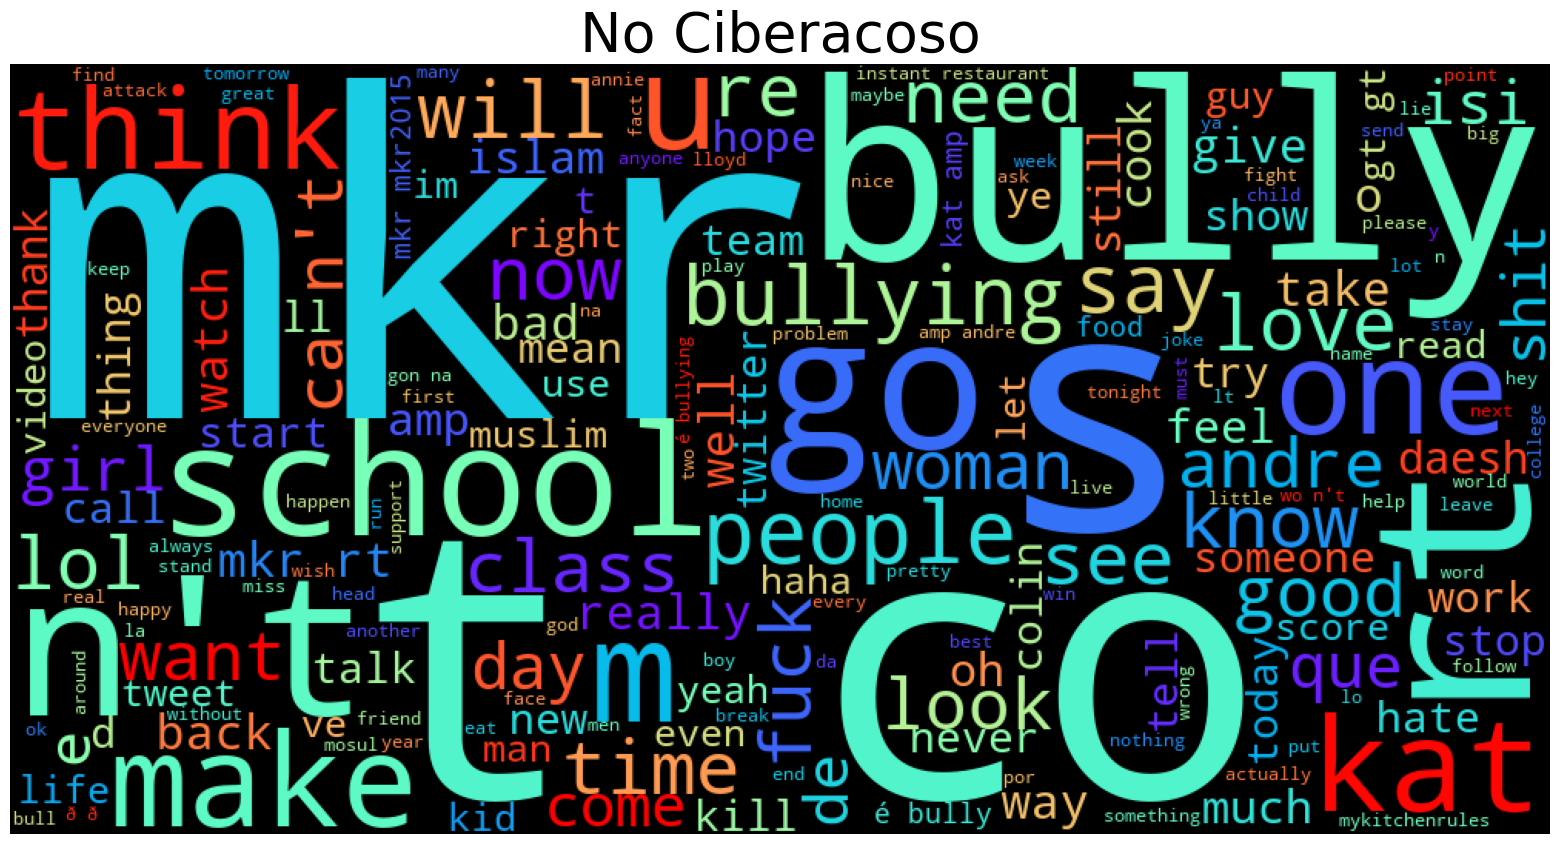

In [388]:
# Wordcloud of other CB
plt.figure(figsize=(20,10))
subset6 = data[data['cyberbullying_type']=='not_cyberbullying']
texto_no = subset6.tweet_text.values
texto_no = texto_no.tolist()
cloud_no =WordCloud(background_color='black',colormap="rainbow", collocations=True, width=1000,height=500).generate(" ".join(texto_no))

plt.axis('off')
plt.title("No Ciberacoso",fontsize=40)
plt.imshow(cloud_no)

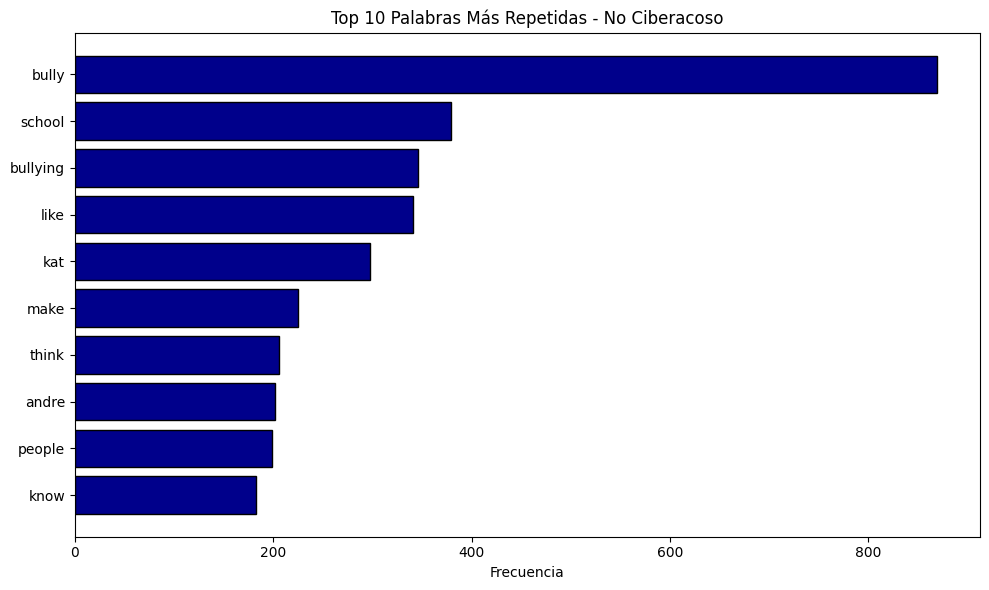

In [390]:
# Top 10 words of other CB
top_10_no = top_words(texto_no, top_k=10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_no['word'][::-1], top_10_no['count'][::-1], color='darkblue', edgecolor='black')
plt.xlabel('Frecuencia')
plt.title('Top 10 Palabras Más Repetidas - No Ciberacoso')
plt.tight_layout()
plt.show()